In [1]:
# ================= Standard Libraries =================
import time
from collections import Counter
from IPython.display import clear_output, display, Math, Markdown
import warnings


# ================= Data Handling ======================
import pandas as pd
import numpy as np
import os

# ================= Visualization =======================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ================= Scikit-Learn ========================
from sklearn import preprocessing, decomposition, cluster, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances_argmin_min, mean_absolute_percentage_error, mean_squared_error

# ================= Statsmodels =========================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot, ProbPlot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ================= SciPy Stats =========================
from scipy.stats import shapiro, kruskal
import scipy.stats as st

# ================= Prediction Stats =========================
from pmdarima import auto_arima

In [2]:
# Le MAPE (Mean Absolute Percentage Error) est un chiffre qui te dit à quel point un modèle de prévision s'est trompé, en pourcentage.
def mape(y_true, y_pred):
    erreur = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    precision = 100 - erreur
    return print(f"Précision du modèle : {precision:.2f}%")

### Mise en situation
Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

Les énergies renouvelables : des sources inépuisables et réutilisables
Selon la définition de l’INSEE, les énergies renouvelables sont les « énergies dérivées de processus naturels en perpétuel renouvellement, notamment celles d’origine solaire, éolienne, hydraulique, géothermique ou végétale ». 

Plus simplement, les énergies d’origine renouvelables sont issues des éléments naturels : le soleil, le vent, les chutes d’eau, les marées, la chaleur de la Terre, la croissance des végétaux… Souvent, on qualifie les énergies renouvelables d’énergies “flux” par opposition aux énergies “stock”, elles-mêmes constituées de gisements limités de combustibles fossiles (pétrole, charbon, gaz, uranium). Contrairement à celle des énergies fossiles, l’exploitation des énergies renouvelables n’engendre pas ou peu de déchets et d’émissions polluantes. 

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !

### Mission
Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

- Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
- Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
- Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage -exponentiel) puis la méthode SARIMA sur la série temporelle.

#### Dataset consommation d'énérgies 

In [3]:
dataConso = pd.read_csv("resources/data/data_conso.csv", parse_dates=True)
dataConso.head()

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0


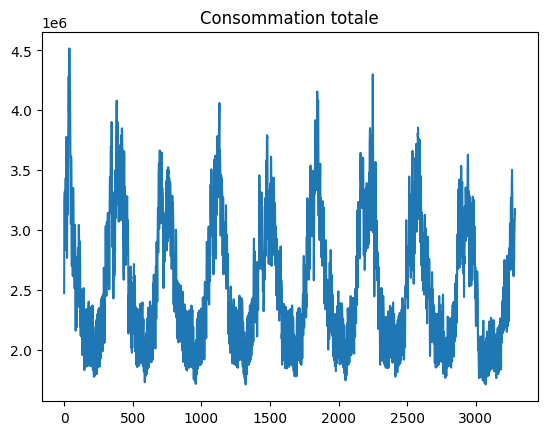

In [4]:
plt.plot(dataConso.consommation)
plt.title("Consommation totale")
plt.show()

In [5]:
conso = dataConso.copy()

# Convertir la colonne 'date' en datetime
conso["date"] = pd.to_datetime(conso["date"])

# Ajouter une colonne 'mois' en format période (année-mois)
conso["mois"] = conso["date"].dt.to_period("M")
# Grouper par 'mois' et sommer uniquement les colonnes numériques
monthConso = conso.groupby('mois', as_index=False).sum(numeric_only=True)
monthConso['mois'] = monthConso['mois'].dt.to_timestamp()
monthConso.head(2)

,mois,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0
1,2012-02-01,108364070.0,217363100.0,216323300.0,2070743.0,5111869.0,9966798.0,77305538.0,2242160.0,404651.0,10405047.0,-835944.0,924169.0


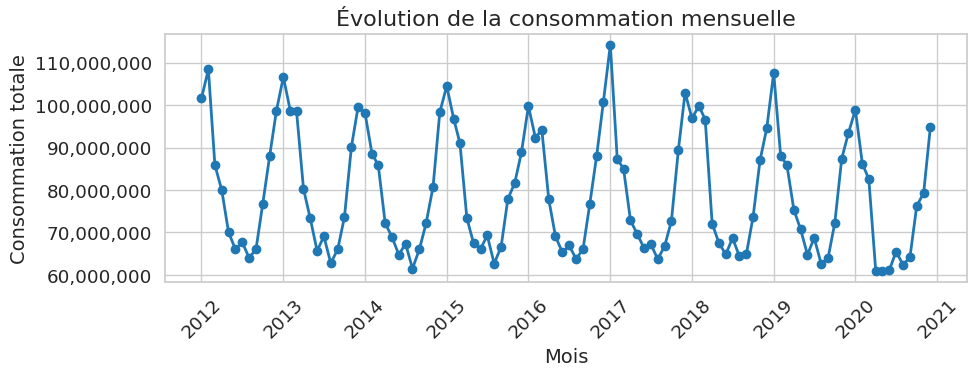

In [6]:
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 4))
plt.plot(monthConso['mois'], monthConso['consommation'], marker='o', color='tab:blue', linewidth=2)

plt.title('Évolution de la consommation mensuelle', fontsize=16)
plt.xlabel('Mois', fontsize=14)
plt.ylabel('Consommation totale', fontsize=14)

# Formater l'affichage des dates sur l'axe x
date_form = DateFormatter("%Y")
ax = plt.gca()
ax.xaxis.set_major_formatter(date_form)

# Formater l'axe y pour afficher des nombres entiers complets sans notation scientifique
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('resources/img/consommations.png', transparent=True)
plt.show()

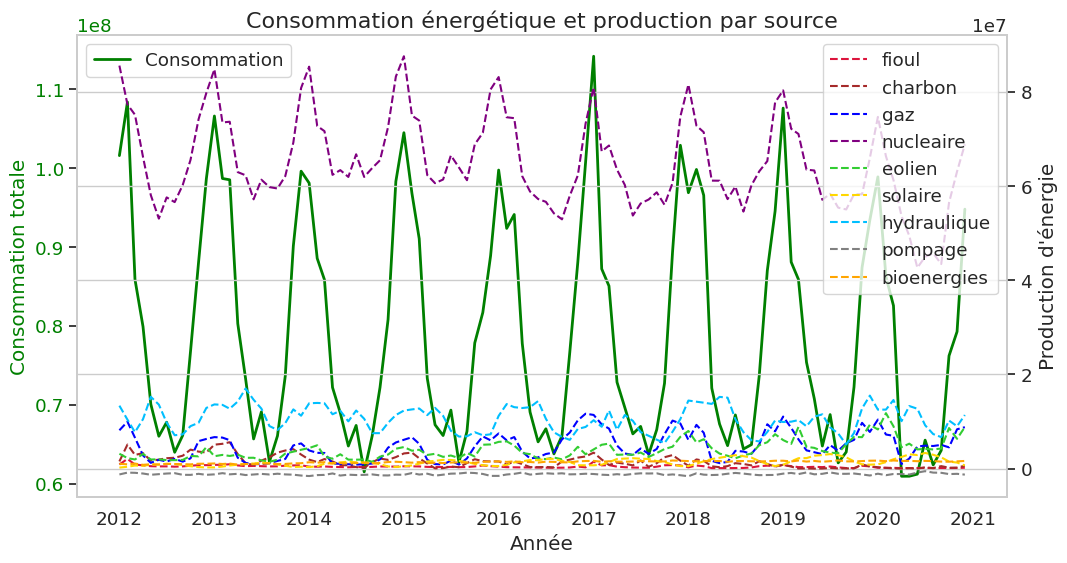

In [7]:
monthConso['mois'] = pd.to_datetime(monthConso['mois'])

energies = ["fioul", "charbon", "gaz", "nucleaire", "eolien", "solaire", "hydraulique", "pompage", "bioenergies"]

# Définir une palette de couleurs
colors = ["crimson", "brown", "blue", "purple", "limegreen", "gold", "deepskyblue", "gray", "orange"]

# Création de la figure et des axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracer la consommation totale
ax1.plot(monthConso['mois'], monthConso['consommation'], label="Consommation", color="green", linewidth=2)
ax1.set_xlabel("Année")
ax1.set_ylabel("Consommation totale", color="green")
ax1.tick_params(axis='y', labelcolor="green")
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Production d'énergie")
for source, colorPal in zip(energies, colors):
    ax2.plot(monthConso['mois'], monthConso[source], label=source, color=colorPal, linewidth=1.5, linestyle="--")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.title("Consommation énergétique et production par source", fontsize=16)
plt.savefig('resources/img/consommations_energies.png', transparent=True)
plt.show()

#### DJU Définition

Le degré jour est une valeur représentative de la différence entre la température d’une journée donnée et un seuil de température de référence (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ces écarts permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

Ils permettent d’estimer la consommation d’énergie pour le chauffage, de comparer les hivers d’une année à l’autre et d’anticiper la demande en énergie.

Plus simplement plus les DJU sont élever plus il fait froid. Dans notre dataset il faut comprendre que c'est le cumul des dégres par jours 


In [8]:
# donnnee du chauffage
dju = pd.read_excel("resources/data/calcul_DJU.xlsx", header=None, skiprows=10)
dju.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,STATIONS,ANNEE,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,01 - AMBERIEU,2022,890.8,663.6,651.6,585.8,382.4,253.2,249.7,232.1,409.8,587.4,599,746.7,6252


In [9]:
dju.columns = [
    "STATIONS", "ANNEE", "JAN", "FÉV", "MAR", "AVR", "MAI", "JUN",
    "JUI", "AOÛ", "SEP", "OCT", "NOV", "DÉC", "TOTAL"
]

# Si la colonne TOTAL n'est pas correcte ou absente, la recalculer
dju["TOTAL"] = dju[["JAN", "FÉV", "MAR", "AVR", "MAI", "JUN", "JUI", "AOÛ", "SEP", "OCT", "NOV", "DÉC"]].sum(axis=1)

# Conversion des mois en colonnes numériques 
month_map = {
    "JAN": 1, "FÉV": 2, "MAR": 3, "AVR": 4, "MAI": 5, "JUN": 6,
    "JUI": 7, "AOÛ": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DÉC": 12
}

dju.rename(columns=month_map, inplace=True)
dju = dju.iloc[1:].reset_index(drop=True)
djuGlobal = dju.copy()
dju.head(2)

,STATIONS,ANNEE,1,2,3,4,5,6,7,8,9,10,11,12,TOTAL
0,01 - AMBERIEU,2022,890.8,663.6,651.6,585.8,382.4,253.2,249.7,232.1,409.8,587.4,599,746.7,6252.1
1,01 - AMBERIEU,2021,865.1,629.9,700.4,619.1,535.8,299.1,328.1,350.1,348.8,585.5,760.6,817,6839.5


In [10]:
stations = dju["STATIONS"].unique()
stations

array(['01 - AMBERIEU', '02 - ST QUENTIN', '03 - VICHY-CHARMEIL',
       '04 - ST AUBAN', '05 - EMBRUN', '06 - CANNES', '06 - NICE',
       '07 - LANAS SYN', '08 - CHARLEVILLE-MEZ', '09 - ST GIRONS',
       '10 - TROYES-BARBEREY', '11 - CARCASSONNE', '12 - MILLAU',
       '13 - AIX EN PROVENCE', '13 - MARSEILLE', '14 - CAEN-CARPIQUET',
       '15 - AURILLAC', '16 - COGNAC', '17 - LA ROCHELLE AERODROME',
       '18 - BOURGES', '19 - BRIVE', '21 - DIJON-LONGVIC',
       '22 - ST BRIEUC', '23 - GUERET-ST LAURENT', '24 - BERGERAC',
       '25 - BESANCON', '26 - MONTELIMAR', '27 - EVREUX-HUEST',
       '28 - CHARTRES', '29 - BREST-GUIPAVAS', '30 - NIMES-COURBESSAC',
       '31 - TOULOUSE-BLAGNAC', '32 - AUCH', '33 - BORDEAUX-MERIGNAC',
       '33 - LEGE-CAP-FERRET', '34 - MONTPELLIER',
       '35 - RENNES-ST JACQUES', '36 - CHATEAUROUX  DEOLS', '37 - TOURS',
       '38 - GRENOBLE-ST GEOIRS', '39 - LONS LE SAUNIER', '40 - DAX',
       '41 - BLOIS', '42 - ST ETIENNE-BOUTHEON', '43 - LE PUY-LO

In [11]:
# Vérification des colonnes
monthColumn = [col for col in range(1, 13) if col in dju.columns]
print("Month Columns:", monthColumn)
if not monthColumn:
    monthColumn = [str(col) for col in range(1, 13) if str(col) in dju.columns]
    print("String Month Columns:", monthColumn)

# Sélection des colonnes
selectedColumn = ["STATIONS", "ANNEE"] + monthColumn
print("Selected Columns:", selectedColumn)

# Filtre DataFrame
djuFilter = dju[selectedColumn]
print("Filtered DataFrame Shape:", djuGlobal.shape)

# Transforming into long format
djuCleared = djuFilter.melt(id_vars=["STATIONS", "ANNEE"], var_name="mois", value_name="chauffage")
print("After Melting Shape:", djuGlobal.shape)
print(djuCleared.head())

# Vérification 
print("Final DataFrame:")
djuCleared.head()

Month Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Selected Columns: ['STATIONS', 'ANNEE', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Filtered DataFrame Shape: (1100, 15)
After Melting Shape: (1100, 15)
        STATIONS ANNEE mois chauffage
0  01 - AMBERIEU  2022    1     890.8
1  01 - AMBERIEU  2021    1     865.1
2  01 - AMBERIEU  2020    1     794.4
3  01 - AMBERIEU  2019    1       862
4  01 - AMBERIEU  2018    1     695.7
Final DataFrame:


,STATIONS,ANNEE,mois,chauffage
0,01 - AMBERIEU,2022,1,890.8
1,01 - AMBERIEU,2021,1,865.1
2,01 - AMBERIEU,2020,1,794.4
3,01 - AMBERIEU,2019,1,862
4,01 - AMBERIEU,2018,1,695.7


In [12]:
# Transformer le DataFrame 'djuCleared' en format long
dataChauffageCleared = djuCleared.reset_index().melt(id_vars=["STATIONS", "ANNEE", "mois"], value_vars=["chauffage"], var_name="variable", value_name="valeur")

# Renommer les colonnes pour plus de clarté
# Convert mois to string if it's not already
dataChauffageCleared["mois"] = dataChauffageCleared["mois"].astype(str)

# Créer la colonne date
dataChauffageCleared["date"] = pd.to_datetime(dataChauffageCleared["ANNEE"].astype(str) + "-" + dataChauffageCleared["mois"].str.zfill(2) + "-01")

# Sélectionner uniquement les colonnes nécessaires
dataChauffageCleared = dataChauffageCleared[["STATIONS",'date', 'valeur']]  # Change 'chauffage' to 'valeur'

# Sauvegarder si nécessaire
dataChauffageCleared.to_csv("resources/data/valid/chauffage_cleared.csv", index=False)
dataChauffageCleared.head()

,STATIONS,date,valeur
0,01 - AMBERIEU,2022-01-01,890.8
1,01 - AMBERIEU,2021-01-01,865.1
2,01 - AMBERIEU,2020-01-01,794.4
3,01 - AMBERIEU,2019-01-01,862
4,01 - AMBERIEU,2018-01-01,695.7


In [13]:
chauffage = pd.read_csv("resources/data/valid/chauffage_cleared.csv", parse_dates=True)
chauffage.head()

,STATIONS,date,valeur
0,01 - AMBERIEU,2022-01-01,890.8
1,01 - AMBERIEU,2021-01-01,865.1
2,01 - AMBERIEU,2020-01-01,794.4
3,01 - AMBERIEU,2019-01-01,862.0
4,01 - AMBERIEU,2018-01-01,695.7


###### Il manque des villes mais aussi orly est dans le 94 et non dans le 91
Il manque la seine saint denis  (93) et les dom-tom

Nous devons sélectionner un département afin d'évoluer plus simplement dans les recherches.

In [14]:
dju_paris = chauffage[chauffage['STATIONS'] == '75 - PARIS-MONTSOURIS'].copy()
# S'assurer que la colonne "date" est bien en datetime
dju_paris["date"] = pd.to_datetime(dju_paris["date"])
dju_paris.rename(columns={'valeur': 'chauffage_dju'}, inplace=True)
dju_paris.head(2)

,STATIONS,date,chauffage_dju
869,75 - PARIS-MONTSOURIS,2022-01-01,757.4
870,75 - PARIS-MONTSOURIS,2021-01-01,768.7


In [15]:
monthConso.rename(columns={'mois': 'date'}, inplace=True)

In [16]:
consommations = pd.merge(monthConso, dju_paris, on='date', how='left')
consommations['date'] = pd.to_datetime(consommations['date'])
consommations['chauffage_dju'] = consommations['chauffage_dju'].fillna(0)
consommations.head(2)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0
1,2012-02-01,108364070.0,217363100.0,216323300.0,2070743.0,5111869.0,9966798.0,77305538.0,2242160.0,404651.0,10405047.0,-835944.0,924169.0,75 - PARIS-MONTSOURIS,783.9


In [17]:
consommationsEmpty = consommations['chauffage_dju'] == 0
print(consommationsEmpty[consommationsEmpty])

Series([], Name: chauffage_dju, dtype: bool)


In [18]:
consommations.isna().any()

date             False
consommation     False
prevision_j1     False
prevision_j      False
fioul            False
charbon          False
gaz              False
nucleaire        False
eolien           False
solaire          False
hydraulique      False
pompage          False
bioenergies      False
STATIONS         False
chauffage_dju    False
dtype: bool

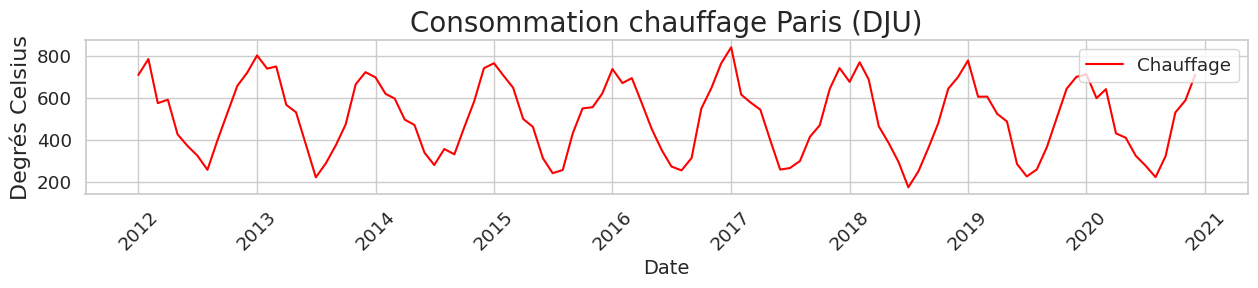

In [19]:
consommations["date"] = pd.to_datetime(consommations["date"])
# Tracer le graphique
plt.figure(figsize=(15, 2))
plt.title("Consommation chauffage Paris (DJU)", fontsize=20)
plt.plot(consommations["date"], consommations["chauffage_dju"], label="Chauffage", color="red")
# Étiquettes des axes
plt.xlabel("Date", fontsize=14)
plt.ylabel("Degrés Celsius", fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
# Affichage du graphique
plt.show()


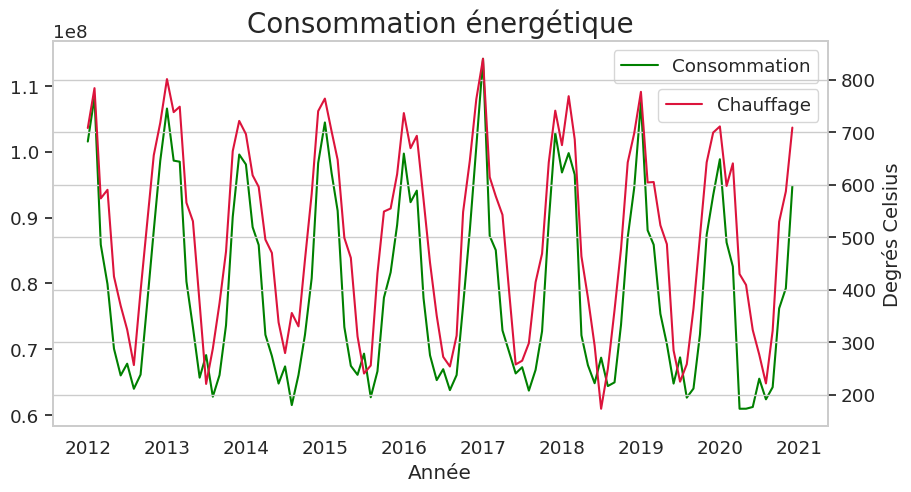

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(consommations['date'], consommations['consommation'], label="Consommation", color="green")
ax1.set_xlabel("Année")
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(consommations['date'], consommations['chauffage_dju'], label="Chauffage", color="crimson")
ax2.set_ylabel("Degrés Celsius", fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

plt.title("Consommation énergétique", fontsize=20)
plt.savefig('resources/img/consommation_energetique.png', transparent=True)
plt.show()

In [21]:
correlationPearson = consommations['consommation'].corr(consommations['chauffage_dju'])
print(f"Coefficient Pearson: {correlationPearson}")

Coefficient Pearson: 0.9349246498346176


## Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

In [22]:
# Données
y = consommations['consommation']
X = consommations[['chauffage_dju']]

# Modèle 
X = sm.add_constant(X)
# Création du modèle de régression linéaire : Ajustez le modèle OLS.
pred_RL = sm.OLS(y, X).fit()

y_pred = pred_RL.predict(X)

print(pred_RL.params)


const            4.065600e+07
chauffage_dju    7.564277e+04
dtype: float64


In [23]:
# const = 40656000 → C’est la consommation de base, quand il ne fait pas froid.
# chauffage_dju = 75643 → C’est l'effet du froid :

# on corrige la consommation d’énergie en enlevant l’effet du chauffage. Plus précisément :
consommations["consommation_corrigees"] = (
    consommations["consommation"] - (consommations["chauffage_dju"] * pred_RL.params["chauffage_dju"])
)

# Formule correction 
# consommation_corrigees =  consommation − (chauffage×coefficient)
# On prend la consommation d’énergie réelle et on enlève la part qui est due au chauffage, d’après ce que le modèle a appris.

print(pred_RL.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     735.8
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.66e-49
Time:                        17:03:50   Log-Likelihood:                -1818.9
No. Observations:                 108   AIC:                             3642.
Df Residuals:                     106   BIC:                             3647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.066e+07   1.49e+06     27.205

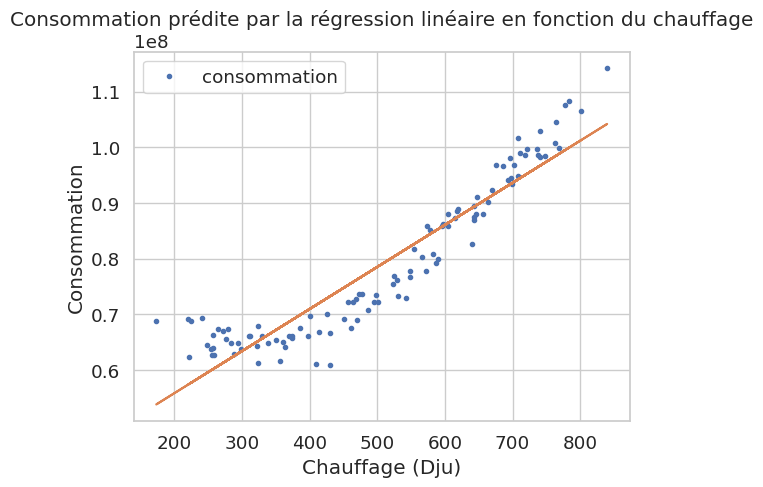

In [24]:
consommations.plot(x='chauffage_dju', y='consommation', style='.')
plt.xlabel('Chauffage (Dju)')
plt.ylabel('Consommation')
plt.title('Consommation prédite par la régression linéaire en fonction du chauffage')
plt.plot(consommations['chauffage_dju'], pred_RL.predict(sm.add_constant(consommations['chauffage_dju'])), label=f'Droite de régression (R² = {pred_RL.rsquared:.2f})')

In [25]:
# Calculer les résidus
regSimp = smf.ols('consommation ~ chauffage_dju', data=consommations).fit()
consommations['consommation_corrigees'] = regSimp.resid
consommations.head(1)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju,consommation_corrigees
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0,7.361998e+06


In [26]:
correlationPearsonRegression = consommations['consommation'].corr(consommations['consommation_corrigees'])
print(f"Coefficient Pearson: {correlationPearson}")

Coefficient Pearson: 0.9349246498346176


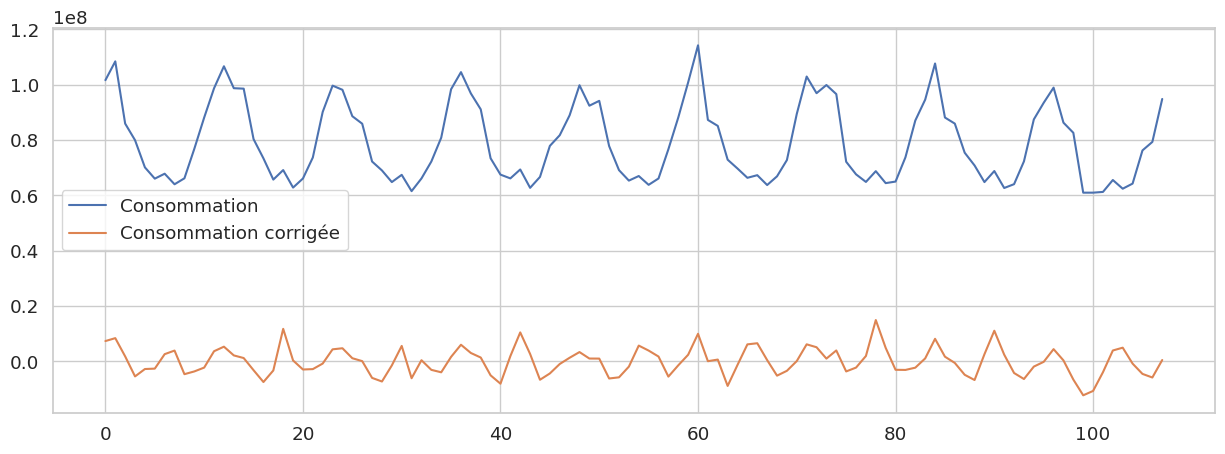

In [27]:
plt.subplots(figsize=(15, 5))
plt.plot(consommations['consommation'], label='Consommation')
plt.plot(consommations['consommation_corrigees'], label='Consommation corrigée')
plt.savefig("resources/img/comparaison_chauffage.png")
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


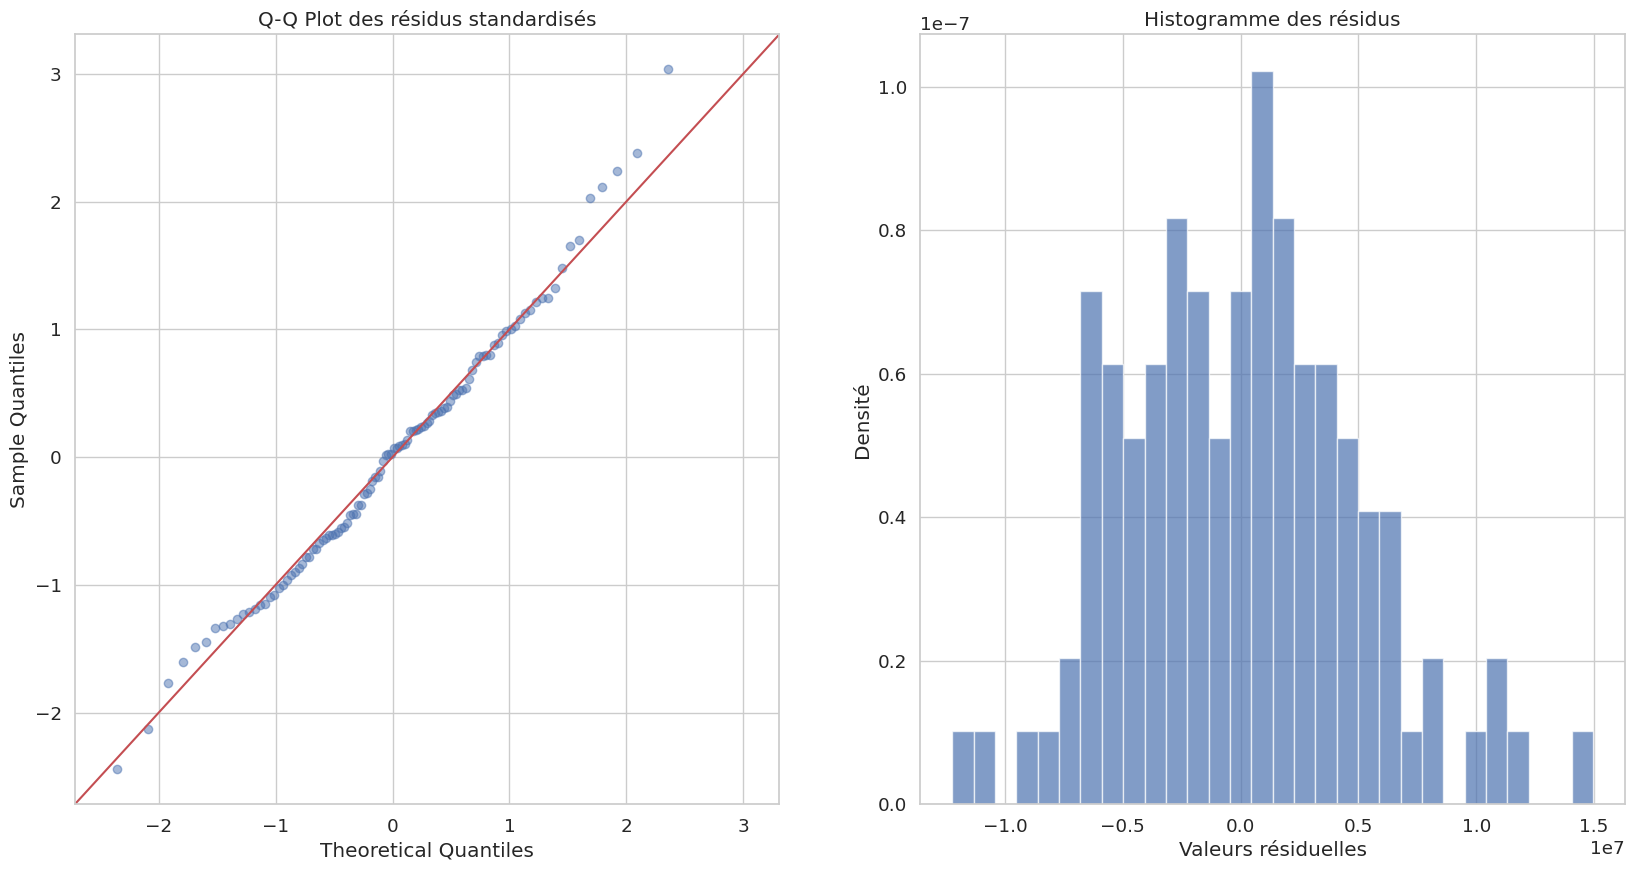

In [28]:
# Création des sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Récupération des résidus
residus = pred_RL.resid

# Histogramme des résidus (axe 1)
ax[1].hist(residus, bins=30, density=True, color='#4C72B0', alpha=0.7)
ax[1].set_title("Histogramme des résidus")
ax[1].set_xlabel("Valeurs résiduelles")
ax[1].set_ylabel("Densité")

# Q-Q plot (axe 0)
model_norm_residuals = pred_RL.get_influence().resid_studentized_internal
qq = ProbPlot(model_norm_residuals)
qq.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])
ax[0].set_title("Q-Q Plot des résidus standardisés")

# Sauvegarde et affichage
plt.savefig('resources/img/residus_reg.png', transparent=True)
plt.show()

#### Le modèle est donc acceptable: 
- Q-Q Plot (à gauche)
- - Les points suivent globalement la ligne rouge
  - Les résidus sontnormalement distribués (avec quelques résidus acceptable)
- Histogramme (à droite)
- - L’histogramme est centré autour de 0, ce qui est attendu.
  - La forme est asymétrique, avec une queue un peu longue à droite
  - Cela indique qu’il y a quelques grandes valeurs de résidus positifs : le modèle sous-estime parfois beaucoup la consommation réelle.
- Les résidus sont assez bien distribués, donc le modèle est globalement correct.
- Il y a quelques valeurs extrêmes → peut-être des outliers ou un phénomène non expliqué par la variable chauffage_dju.



In [29]:
# Le test de Shapiro-Wilk sert à vérifier si une distribution suit une loi normale. 
# Il est souvent utilisé pour tester la normalité des résidus dans une régression.
#Test de Shapiro-Wilk
stat, p_value = shapiro(pred_RL.resid)
print(f"Statistique de Shapiro-Wilk : {stat}")
print(f"p-value : {p_value}")

Statistique de Shapiro-Wilk : 0.9911911487579346
p-value : 0.714260995388031


- - La p-value est largement supérieure à 0.05 → on ne rejette pas l’hypothèse de normalité.
- - Cela signifie que tes résidus suivent une loi normale, ou du moins suffisamment proche pour que le modèle soit considéré comme fiable.

# Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

### Pourquoi désaisonnaliser ?

- Notre objectif est de prédire la consommation future.

- - La saisonnalité :
  - Le modèle peut être perturbé : il risque de "confondre" variations normales (hiver, été) et vraies évolutions (croissance, décroissance de fond).

- - En désaisonnalisant :
  - Tu aides ton modèle à mieux comprendre la vraie dynamique de la consommation d'électricité, indépendamment des saisons.

- Dans le projet précisément :
- - On as déjà corrigé l'effet température (important pour enlever le chauffage électrique).
- - Exemple : même si l’hiver est doux, en janvier, la consommation est toujours un peu plus élevée que la moyenne → la désaisonnalisation va corriger ça.

In [30]:
consommations.columns

Index(['date', 'consommation', 'prevision_j1', 'prevision_j', 'fioul',
       'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire', 'hydraulique',
       'pompage', 'bioenergies', 'STATIONS', 'chauffage_dju',
       'consommation_corrigees'],
      dtype='object')

In [31]:
consommations['date'] = pd.to_datetime(consommations['date'])

consommations.set_index('date', inplace=True)
decomposeSeason = seasonal_decompose(
    consommations['consommation_corrigees'], 
    model='additive',
    period=12
)
seasonValues = decomposeSeason.seasonal
seasonValues

date
2012-01-01    6.051205e+06
2012-02-01    1.466095e+06
2012-03-01    2.772367e+05
2012-04-01   -6.128378e+06
2012-05-01   -6.042803e+06
                  ...     
2020-08-01    1.441841e+06
2020-09-01   -3.085219e+06
2020-10-01   -3.980945e+06
2020-11-01   -1.551824e+06
2020-12-01    2.721028e+06
Name: seasonal, Length: 108, dtype: float64

In [32]:
consommations['consommation_saison'] = consommations['consommation_corrigees'] - seasonValues
consommations['consommation_corrigees'].isnull().sum()
consommations['consommation_corrigees'] = consommations['consommation_corrigees'].fillna(0) 
consommations.to_csv("resources/data/valid/consommations_corrigee_saison.csv", index=False)
consommations.head(2)

,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju,consommation_corrigees,consommation_saison
date,,,,,,,,,,,,,,,,
2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0,7.361998e+06,1.310793e+06
2012-02-01,108364070.0,217363100.0,216323300.0,2070743.0,5111869.0,9966798.0,77305538.0,2242160.0,404651.0,10405047.0,-835944.0,924169.0,75 - PARIS-MONTSOURIS,783.9,8.411706e+06,6.945610e+06


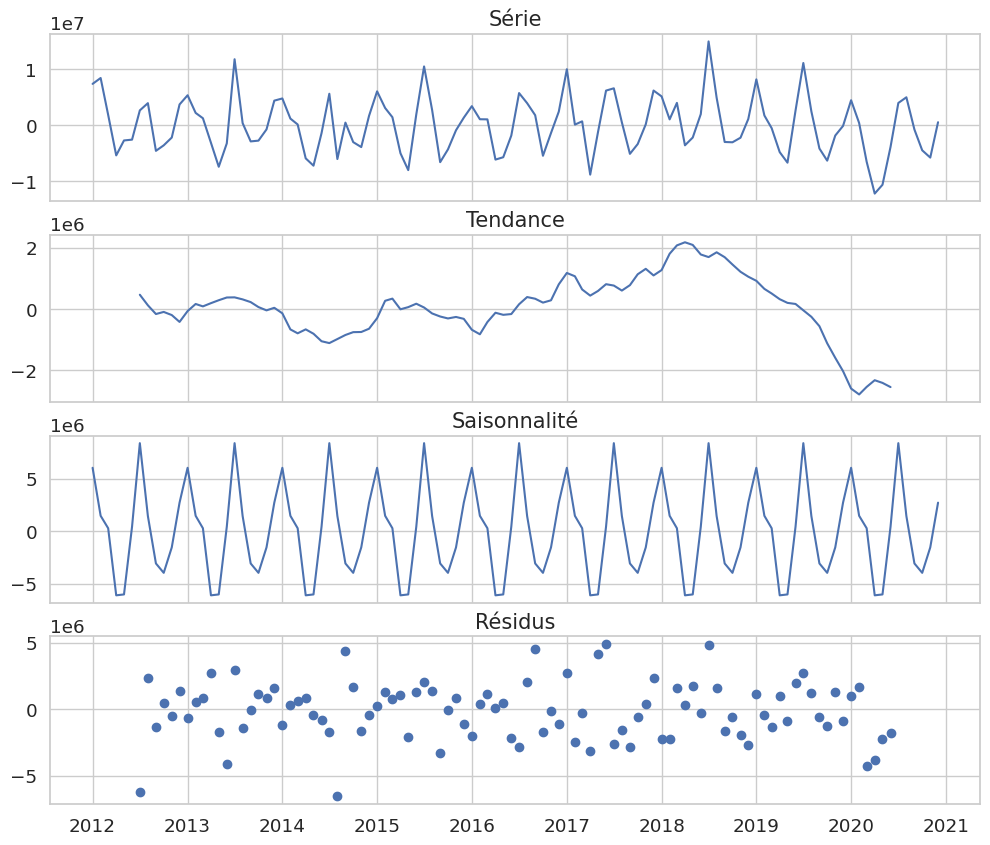

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)  # Partage X pour aligner

ax[0].plot(decomposeSeason.observed)
ax[0].set_title('Série', fontsize=15)

ax[1].plot(decomposeSeason.trend)
ax[1].set_title('Tendance', fontsize=15)

ax[2].plot(decomposeSeason.seasonal)
ax[2].set_title('Saisonnalité', fontsize=15)

ax[3].plot(decomposeSeason.resid, 'bo')
ax[3].set_title('Résidus', fontsize=15)

plt.savefig('resources/img/series_saison.png', transparent=False)


- Série observée : on voit une consommation d'énergie marquée par de fortes fluctuations régulières (saisonnalité) et une certaine variabilité globale.

- Tendance : une tendance générale est visible : la consommation augmente légèrement entre 2016 et 2018 avant de décroître ensuite. Cela montre une évolution lente du comportement énergétique sur plusieurs années.

- Saisonnalité : une forte périodicité annuelle est clairement identifiable, avec des pics récurrents (en hiver) et des creux (en été), liés aux besoins de chauffage et de climatisation.

- Résidus : les résidus semblent répartis de manière assez aléatoire autour de zéro, ce qui indique que la majeure partie de l'information de la série est bien capturée par la tendance + la saisonnalité.

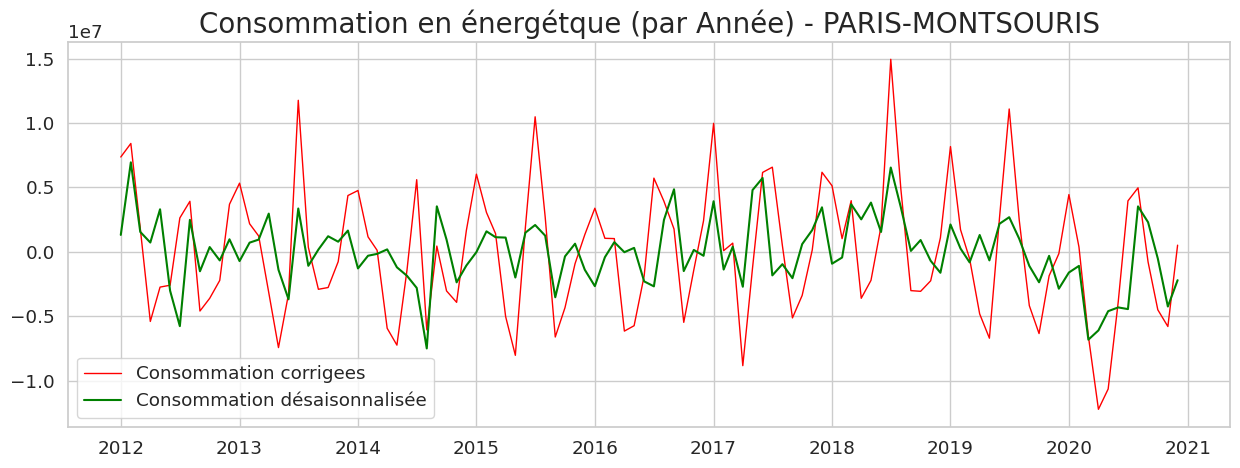

In [34]:
plt.figure(figsize=(15,5))
plt.plot(consommations["consommation_corrigees"], color="red", label="Consommation corrigees", linewidth=1)
plt.plot(consommations["consommation_saison"], color="green", label="Consommation désaisonnalisée")

plt.title("Consommation en énergétque (par Année) - PARIS-MONTSOURIS", fontsize=20), plt.legend()
plt.savefig("Consommation en énergétque (par Année) - PARIS-MONTSOURIS", transparent=True)
plt.savefig('resources/img/conso_desaisonnalisee.png', transparent=True)
plt.show()

In [35]:
consommations = consommations.reset_index()
consommations['date'] = pd.to_datetime(consommations['date'])
consommations.to_csv("resources/data/valid/correction_consommations.csv", index=False)
consommations.head(1)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju,consommation_corrigees,consommation_saison
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0,7.361998e+06,1.310793e+06


- En rouge, la consommation d'énergie corrigée de l'effet température, mais encore soumise à des variations saisonnières.

- En vert, la consommation désaisonnalisée, c'est-à-dire sans les effets réguliers des saisons.

Après désaisonnalisation (courbe verte), ces pics disparaissent presque complètement : la série devient plus stable autour d'une moyenne, et on observe mieux la tendance réelle de la consommation d'énergie.

# Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.


# ExponentialSmoothing

## Définition

`ExponentialSmoothing` est une méthode de prévision de séries temporelles qui utilise le **lissage exponentiel**.  
Elle accorde **plus de poids aux observations récentes** qu'aux plus anciennes, ce qui permet de mieux capturer les évolutions récentes de la série.

# Le lissage exponentiel, c'est quoi ?

Le lissage exponentiel est une méthode pour **prévoir des données dans le temps**.

Le principe est simple :
- **On donne plus d'importance aux données récentes**, 
- **Et un peu moins aux données plus anciennes**.

C'est comme une moyenne, mais **intelligente** :  
plus une information est récente, plus elle compte dans la prévision.

- Le **coefficient** (entre 0 et 1) décide **combien** on fait confiance à la nouvelle valeur.
  - Proche de 1 → on suit beaucoup la nouvelle valeur.
  - Proche de 0 → on suit surtout l'ancienne tendance.

## Pourquoi utiliser le lissage exponentiel ?

 Pour **suivre rapidement** les changements récents,  
 Pour **prévoir facilement** sans avoir un modèle compliqué,  
 Pour **lisser** les petites variations aléatoires et mieux voir la tendance de fond.


## Exemple concret du lissage exponentiel

Imaginons que vous regardiez la consommation d’électricité chaque mois :
- Si la consommation monte soudainement cet hiver,
- Le lissage exponentiel **s’adapte rapidement** pour en tenir compte dans vos prévisions.


## Pourquoi utiliser  `ExponentialSmoothing`?

- **Saisir la tendance** : modéliser une hausse ou une baisse progressive dans la série.
- **Saisir la saisonnalité** : modéliser des motifs récurrents sur une base régulière (par exemple, variations saisonnières).
- **Améliorer les prévisions** : en combinant tendance + saisonnalité, on obtient des prédictions plus précises.


## Application dans ce projet
 
Dans le projet de prévision de la demande en électricité :
- **La tendance** traduit l'évolution générale de la consommation sur plusieurs années.
- **La saisonnalité** capture les fluctuations régulières (ex : consommation plus forte en hiver).
  
Utiliser `ExponentialSmoothing` permet de **prévoir la consommation future** en tenant compte à la fois :
- Des changements longs termes (tendance)
- Et des motifs saisonniers répétés chaque année (saisonnalité)

# Comment fonctionne `ExponentialSmoothing` ?

`ExponentialSmoothing` est un modèle de séries temporelles basé sur le **lissage exponentiel**.  
Il donne **plus d'importance aux données récentes**, tout en tenant compte des anciennes observations.

À chaque nouvelle donnée :
- Le modèle ajuste une **valeur lissée**,
- En utilisant une **formule très simple** qui combine l'ancienne prévision et la nouvelle observation.

La formule ressemble à ça :

---

## Les trois composants du modèle

| Élément       | Rôle dans la série temporelle                    | Exemple réel                          |
|:--------------|:--------------------------------------------------|:--------------------------------------|
| Niveau (**Level**)      | Valeur moyenne actuelle de la série              | Niveau moyen de consommation d'électricité |
| Tendance (**Trend**)    | Évolution progressive (hausse ou baisse)         | Augmentation annuelle de la consommation |
| Saisonnalité (**Seasonality**) | Motifs réguliers qui se répètent dans le temps | Pic de consommation en hiver |

---

## Fonctionnement général

À chaque nouvelle donnée, le modèle :
1. Met à jour le **niveau** (valeur centrale de la série),
2. Met à jour la **tendance** (direction de la série),
3. Met à jour la **saisonnalité** (comportement périodique).

Ces mises à jour utilisent des **coefficients de lissage** :
- **Alpha (α)** : pour ajuster le niveau,
- **Beta (β)** : pour ajuster la tendance,
- **Gamma (γ)** : pour ajuster la saisonnalité.

> Plus le coefficient est proche de 1, plus le modèle est **réactif** aux nouvelles données.



# Holt Winters

In [36]:
dataHoltWinters = pd.read_csv("resources/data/valid/correction_consommations.csv", parse_dates=True)
dataHoltWinters["date"] = pd.to_datetime(dataHoltWinters["date"])
dataHoltWinters.head(1)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju,consommation_corrigees,consommation_saison
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0,7.361998e+06,1.310793e+06


In [37]:
def mapeWinters(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Éviter la division par zéro
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        raise ValueError("Toutes les valeurs de y_true sont nulles, MAPE impossible à calculer.")
    
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [38]:
def holt_winters_forecast_plot(df, forecast_periods=12, suffix="default", mode="forecast", y_true=None, comparaison_dfs=None):
    warnings.filterwarnings("ignore")

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    y = np.asarray(df["consommation_corrigees"])

    model = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
    forecast = model.forecast(forecast_periods)
    fitted = model.fittedvalues

    last_date = df["date"].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

    # ➤ MODE = forecast
    if mode == "forecast":
        fig, ax = plt.subplots(figsize=(15, 5))
        
        ax.plot(df["date"], df["consommation_corrigees"], label="Consommation réelle")
        ax.plot(future_dates, forecast, label="Prévision Holt-Winters", color="orange")
        ax.set_title(f"Prévision consommation ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrigée")
        ax.legend()
        ax.grid(True)
        
        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/prevision_consommation_{suffix}.png", transparent=True)
        plt.show()

        if len(y) >= forecast_periods:
            mape_val = mapeWinters(y[-forecast_periods:], forecast)
            print(f"MAPE : {mape_val:.2f}%")

    # ➤ MODE = verify
    elif mode == "verify":
        if y_true is None:
            raise ValueError("y_true est requis en mode 'verify'.")

        y_true = np.asarray(y_true)
        if len(y_true) != forecast_periods:
            raise ValueError("y_true doit avoir la même longueur que forecast_periods")

        fig, ax = plt.subplots(figsize=(15, 5))

        # ➤ Consommation réelle historique
        ax.plot(df["date"], df["consommation_corrigees"], label="Historique", color='blue')
        
        # ➤ Prévision année N-1
        if len(df) >= 12 + forecast_periods:
            df_n1 = df.iloc[:-12]
            y_n1 = np.asarray(df_n1["consommation_corrigees"])
            model_n1 = ExponentialSmoothing(y_n1, seasonal_periods=12, trend='add', seasonal='add').fit()
            forecast_n1 = model_n1.forecast(forecast_periods)
            future_dates_n1 = pd.date_range(start=df_n1["date"].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_n1, forecast_n1, label="Prévision année N-1", linestyle=':', color='green')

        # ➤ Prévision année N-2
        if len(df) >= 24 + forecast_periods:
            df_n2 = df.iloc[:-24]
            y_n2 = np.asarray(df_n2["consommation_corrigees"])
            model_n2 = ExponentialSmoothing(y_n2, seasonal_periods=12, trend='add', seasonal='add').fit()
            forecast_n2 = model_n2.forecast(forecast_periods)
            future_dates_n2 = pd.date_range(start=df_n2["date"].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_n2, forecast_n2, label="Prévision année N-2", linestyle='--', color='purple')

        ax.set_title(f"Vérification des prévisions ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrigée")
        ax.legend()
        ax.grid(True)

        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/verification_consommation_{suffix}.png", transparent=True)
        plt.show()

        mapeVal = mapeWinters(y_true, forecast)
        print(f"MAPE (Erreur moyenne absolue en pourcentage) : {mapeVal:.2f}%")

    # ➤ Comparaison facultative
    if comparaison_dfs and mode == "forecast":
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(df["date"], df["consommation_corrigees"], label="Consommation réelle", color='blue')

        for comp_label, comp_df in comparaison_dfs:
            comp_df = comp_df.copy()
            comp_df["date"] = pd.to_datetime(comp_df["date"])
            y_comp = np.asarray(comp_df["consommation_corrigees"])
            model_comp = ExponentialSmoothing(y_comp, seasonal_periods=12, trend='add', seasonal='add').fit()
            pred_comp = model_comp.forecast(forecast_periods)
            last_date_comp = comp_df["date"].iloc[-1]
            future_dates_comp = pd.date_range(start=last_date_comp + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_comp, pred_comp, label=f"Prévision {comp_label}", linestyle='--')

        ax.set_title(f"Comparaison des prévisions ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrigée")
        ax.legend()
        ax.grid(True)
        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/prevision_comparee_{suffix}.png", transparent=True)
        plt.show()

    return forecast, future_dates


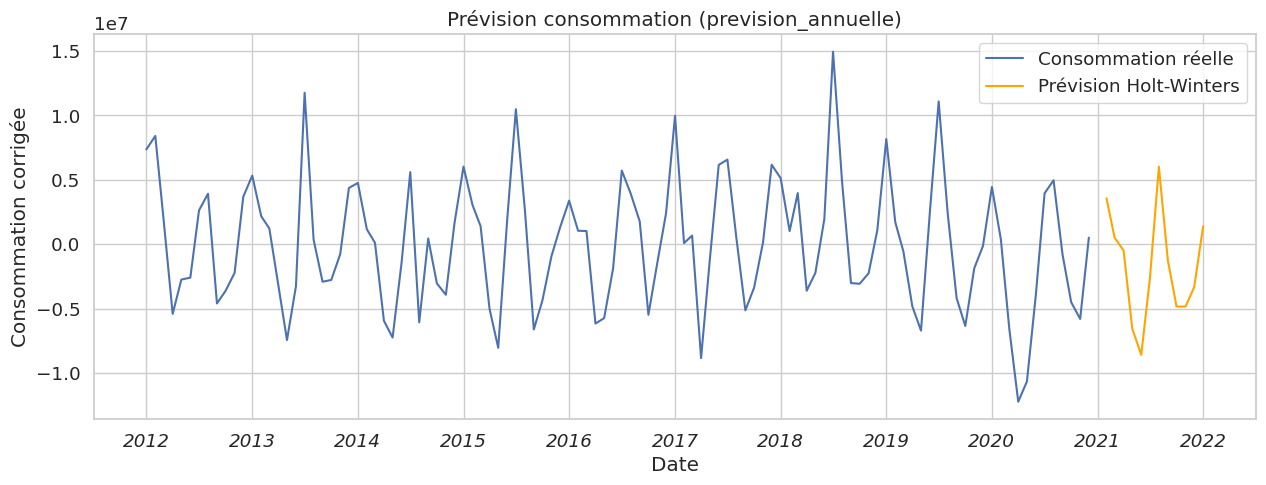

MAPE : 0.97%


(array([ 3564041.95073871,   507780.20149789,  -482817.394446  ,
        -6553031.90508728, -8591295.04360526, -2640987.0000771 ,
         6019969.59755168, -1260952.19563776, -4831392.42949101,
        -4844344.91007915, -3330482.39161481,  1404763.48434482]),
 DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
                '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
                '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
               dtype='datetime64[ns]', freq='ME'))

In [39]:
holt_winters_forecast_plot(
    df=dataHoltWinters,
    forecast_periods=12,
    suffix="prevision_annuelle",
    mode="forecast"
)

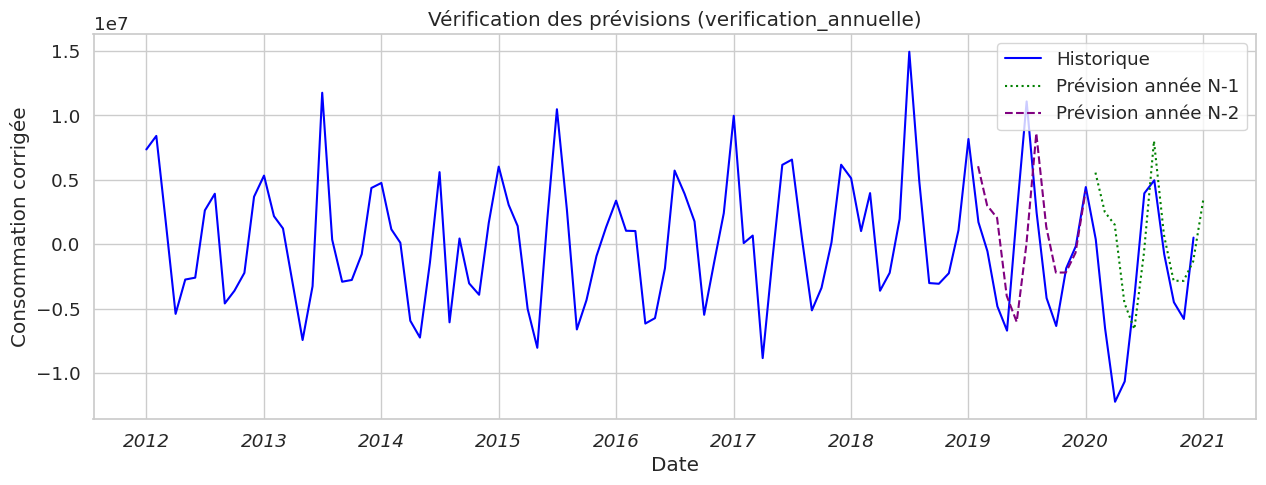

MAPE (Erreur moyenne absolue en pourcentage) : 0.97%


(array([ 3564041.95073871,   507780.20149789,  -482817.394446  ,
        -6553031.90508728, -8591295.04360526, -2640987.0000771 ,
         6019969.59755168, -1260952.19563776, -4831392.42949101,
        -4844344.91007915, -3330482.39161481,  1404763.48434482]),
 DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
                '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
                '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
               dtype='datetime64[ns]', freq='ME'))

In [40]:
forecast_periods = 12
dataHoltWinters = dataHoltWinters.sort_values("date")
dataHoltWinters["date"] = pd.to_datetime(dataHoltWinters["date"])

# 3. Séparer les données en historique + réel
historical_df = dataHoltWinters.iloc[:-forecast_periods].copy()
y_truth = dataHoltWinters.iloc[-forecast_periods:]["consommation_corrigees"].values

holt_winters_forecast_plot(
    df=dataHoltWinters,
    forecast_periods=12,
    suffix="verification_annuelle",
    mode="verify",
    y_true=y_truth
)

In [62]:
def ajusterModeleHoltWinters(serie):
    """
    Ajuste un modèle Holt-Winters multiplicatif avec saisonnalité de 12 mois.
    """
    modele = ExponentialSmoothing(
        serie,
        trend='add',             # ou 'mul' selon ta série
        seasonal='add',          # ou 'add' si la saisonnalité est additive
        seasonal_periods=12,
        initialization_method="estimated"
    )
    resultat = modele.fit()
    return resultat

# Méthode SARIMA

## Définition

SARIMA (Seasonal AutoRegressive Integrated Moving Average) est un modèle de prévision qui permet de prédire l’avenir à partir des données passées en tenant compte des saisons (mois, semaines, etc.).

# 📈 Comprendre ADF, ACF et PACF pour la Prédiction de la Consommation avec SARIMA

Dans un projet de **prédiction de la consommation** (ex. éléctricité, énergie, eau, gaz), il est essentiel de comprendre la structure de la série temporelle avant de modéliser. Les outils clés sont :

- Le **test de Dickey-Fuller Augmenté (ADF)**,
- Les **autocorrélations (ACF)**,
- Les **autocorrélations partielles (PACF)**.

Ils permettent de vérifier si les **conditions nécessaires à l’utilisation du modèle SARIMA** sont remplies.

---

## ✅ 1. Test de Dickey-Fuller Augmenté (ADF)

### 🔎 Définition simple
Le test ADF permet de vérifier si une série temporelle est **stationnaire**, c’est-à-dire si sa **moyenne** et sa **variance** restent **stables dans le temps**.

> _Une série stationnaire_ est une série temporelle dont les propriétés statistiques ne varient pas avec le temps. Elle n’a ni tendance (_trend_) ni saisonnalité persistante.

### 🔎 Interprétation du test

Le test renvoie une **statistique ADF** ainsi qu’une **p-value**. C’est cette p-value qui permet de conclure sur la stationnarité.

| p-value         | Conclusion                           |
|-----------------|---------------------------------------|
| **< 0.05**      | ✅ La série est **stationnaire**       |
| **≥ 0.05**      | ❌ La série est **non stationnaire**   |

---

### 🧠 Pourquoi c’est important ?
Le modèle **SARIMA** (Saisonnal ARIMA) suppose que la série est stationnaire.  
Si la série n'est **pas stationnaire**, on ne peut pas l’utiliser directement dans SARIMA : il faut la transformer via des **différenciations (paramètres `d` et `D`)**.

### 📌 Interprétation
- **H₀ (hypothèse nulle)** : la série **n’est pas stationnaire**.
- Si **p-value < 0.05** → ❗ on rejette H₀ → la série est **stationnaire ✅**.
- Sinon → ❌ la série est **non stationnaire**, on applique `.diff()` ou une différenciation saisonnière.

---

## 🔄 2. ACF — Autocorrelation Function

### 🔎 Définition simple
L’**ACF** mesure l’influence des valeurs passées sur la valeur actuelle pour différents **décalages (lags)**.

Concrètement, elle indique **dans quelle mesure la consommation d’aujourd’hui dépend de celle des jours précédents**.

Pour chaque **décalage temporel** (ou **lag**), on calcule la **force de cette dépendance** :

- **lag = 1** → compare aujourd’hui avec **hier**  
- **lag = 7** → compare aujourd’hui avec **la semaine dernière**
- **lag = 30** → compare aujourd’hui avec **le même jour du mois dernier**


### 🧠 Pourquoi c’est important ?
L’ACF permet :
- d’observer des **saisonnalités** (pics réguliers),
- de déterminer si une **différenciation est nécessaire** (si la décroissance est lente),
- de choisir l’ordre du **terme MA (Moving Average)** dans SARIMA.

### 📌 Exemple
- Si l’ACF **décroît lentement** → tendance non stationnaire → il faut **différencier**.
- Si l’ACF **chute vite** → série probablement stationnaire.

---

## 🔁 3. PACF — Partial Autocorrelation Function

### 🔎 Définition simple
La **PACF** mesure la **corrélation directe** entre une observation et une observation précédente (ex : `t` et `t-1`), en **éliminant l'effet des autres lags** intermédiaires.

> Autrement dit : PACF montre **le lien direct entre la consommation d’aujourd’hui et celle de n jours avant**, **en ignorant ce qui s’est passé entre-temps**.

### 🧠 Pourquoi c’est important ?
La PACF permet de :
- déterminer le nombre de **termes AR (Auto-Régressifs)** à inclure dans le modèle SARIMA,
- identifier les **dépendances directes** sur les valeurs passées.

### 📌 Exemple
- Si la PACF est significative jusqu’au lag 2 → on peut tester un modèle avec **AR(2)**.

---

> ✅ **Conclusion :** Avant d’utiliser un modèle SARIMA pour prédire la consommation, il est indispensable de vérifier la stationnarité (ADF), puis d’analyser les dépendances temporelles (ACF et PACF) pour choisir les bons paramètres.


In [41]:
dataSarima = pd.read_csv("resources/data/valid/correction_consommations.csv", parse_dates=True)
dataSarima.head(1)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,STATIONS,chauffage_dju,consommation_corrigees,consommation_saison
0,2012-01-01,101573076.0,201985150.0,201244900.0,893223.0,1537770.0,8150964.0,85553029.0,3170579.0,233044.0,13372457.0,-1222987.0,1039213.0,75 - PARIS-MONTSOURIS,708.0,7.361998e+06,1.310793e+06


In [42]:
def test_stationarity_with_adf(series, lags=30, title=''):
    """
    Effectue le test de Dickey-Fuller augmenté (ADF) et affiche les ACF/PACF.
    
    Si la série est stationnaire, enregistre les graphiques dans des fichiers PNG.

    Arguments :
    - series : pd.Series
    - lags : int
    - title : str
    """

    # Nettoyage de la série
    series_clean = series.dropna()

    # Forcer l'index en datetime si nécessaire
    if not np.issubdtype(series_clean.index.dtype, np.datetime64):
        try:
            series_clean.index = pd.to_datetime(series_clean.index)
        except Exception as e:
            print("Erreur : impossible de convertir l'index en datetime :", e)

    n_obs = len(series_clean)
    max_lags = min(lags, n_obs // 2 - 1)

    # === Plot de la série temporelle ===
    plt.figure(figsize=(10, 4))
    plt.plot(series_clean, label='Série temporelle')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()

    plt.title(f'Série temporelle - {title}')
    plt.xlabel('Temps')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Test ADF ===
    print("=== Test de Dickey-Fuller augmenté ===")
    result = adfuller(series_clean, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# lags used', '# observations']
    for value, label in zip(result[:4], labels):
        print(f"{label} : {value}")

    print("Valeurs critiques :")
    for key, val in result[4].items():
        print(f"   {key} : {val}")

    is_stationary = result[1] <= 0.05
    if is_stationary:
        print("\n✅ La série est stationnaire (on rejette l'hypothèse nulle H0)")
    else:
        print("\n❌ La série n'est PAS stationnaire (on ne rejette pas H0)")

    # === ACF & PACF ===
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(series_clean, ax=axes[0], lags=max_lags)
    axes[0].set_title("ACF - Corrélation automatique")

    plot_pacf(series_clean, ax=axes[1], lags=max_lags, method='ywm')
    axes[1].set_title("PACF - Corrélation partielle")

    plt.tight_layout()
    plt.show()

    # === Enregistrement si stationnaire ===
    if is_stationary:
        folder = "resources/img"
        os.makedirs(folder, exist_ok=True)

        # Replot & save série temporelle
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(series_clean, label='Série temporelle')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        fig.autofmt_xdate()
        ax.set_title(f'Série temporelle - {title}')
        ax.set_xlabel('Temps')
        ax.set_ylabel('Valeur')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        fig.savefig(f"{folder}/{title}_serie_temporelle.png")
        plt.close(fig)

        # Replot & save ACF & PACF
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        plot_acf(series_clean, ax=axes[0], lags=max_lags)
        axes[0].set_title("ACF - Corrélation automatique")

        plot_pacf(series_clean, ax=axes[1], lags=max_lags, method='ywm')
        axes[1].set_title("PACF - Corrélation partielle")

        plt.tight_layout()
        fig.savefig(f"{folder}/{title}_acf_pacf.png")
        plt.close(fig)

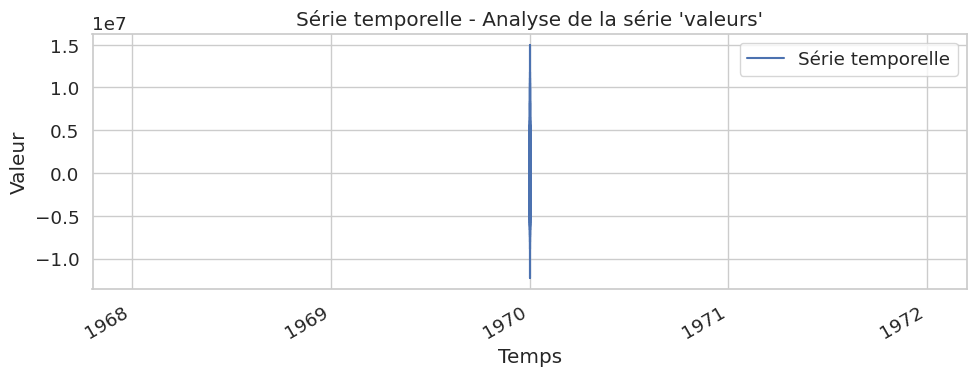

=== Test de Dickey-Fuller augmenté ===
ADF Statistic : -1.782519088863956
p-value : 0.3891743640002461
# lags used : 11
# observations : 96
Valeurs critiques :
   1% : -3.5003788874873405
   5% : -2.8921519665075235
   10% : -2.5830997960069446

❌ La série n'est PAS stationnaire (on ne rejette pas H0)


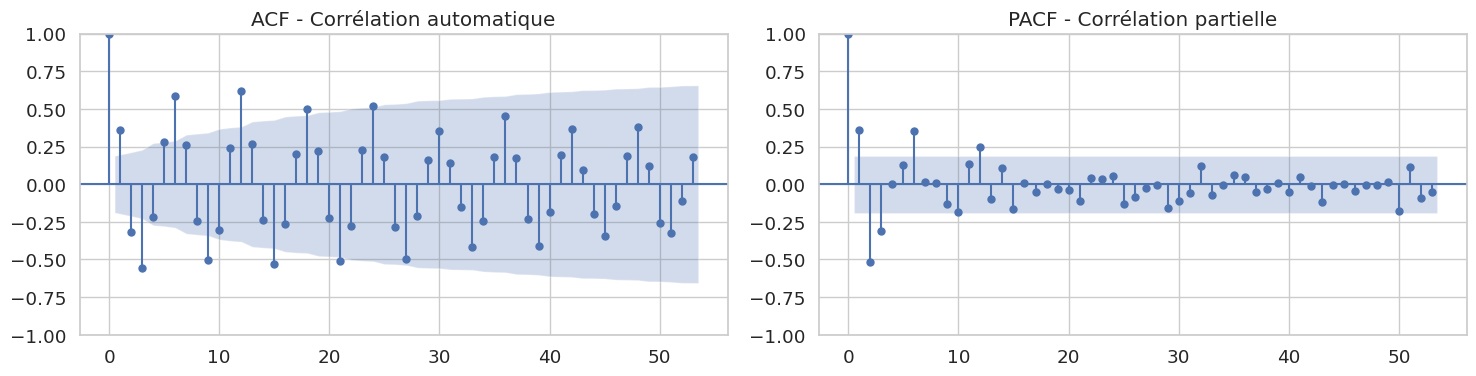

In [43]:
# Test de Dickey–Fuller avec ACF et PACF
test_stationarity_with_adf(dataSarima['consommation_corrigees'], lags=60, title="Analyse de la série 'valeurs'")

In [44]:
cpDfSarima = dataSarima.copy()
cpDfSarima.set_index('date', inplace=True)

numerical_cols = cpDfSarima.select_dtypes(include='number').columns
sarimaLessSixMonth = cpDfSarima[numerical_cols] - cpDfSarima[numerical_cols].shift(6)
sarimaLessSixMonth = sarimaLessSixMonth.dropna()

# La colonne date est maintenant dans l'index
print(sarimaLessSixMonth.index)
print(sarimaLessSixMonth['consommation_corrigees'])

Index(['2012-07-01', '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
       '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
       ...
       '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
      dtype='object', name='date', length=102)
date
2012-07-01   -4.732721e+06
2012-08-01   -4.490706e+06
2012-09-01   -6.421611e+06
2012-10-01    1.795548e+06
2012-11-01    5.194071e+05
                  ...     
2020-08-01    4.595758e+06
2020-09-01    5.756610e+06
2020-10-01    7.728060e+06
2020-11-01    4.851089e+06
2020-12-01    4.405273e+06
Name: consommation_corrigees, Length: 102, dtype: float64


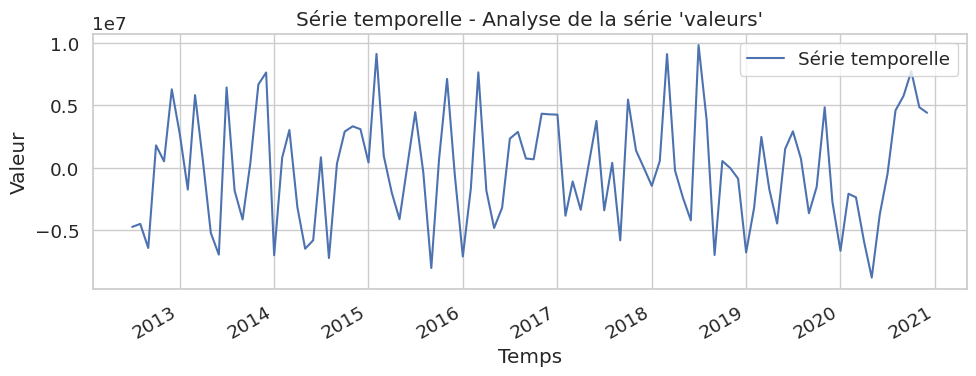

=== Test de Dickey-Fuller augmenté ===
ADF Statistic : -5.8272401371804365
p-value : 4.0523661196268824e-07
# lags used : 7
# observations : 94
Valeurs critiques :
   1% : -3.5019123847798657
   5% : -2.892815255482889
   10% : -2.583453861475781

✅ La série est stationnaire (on rejette l'hypothèse nulle H0)


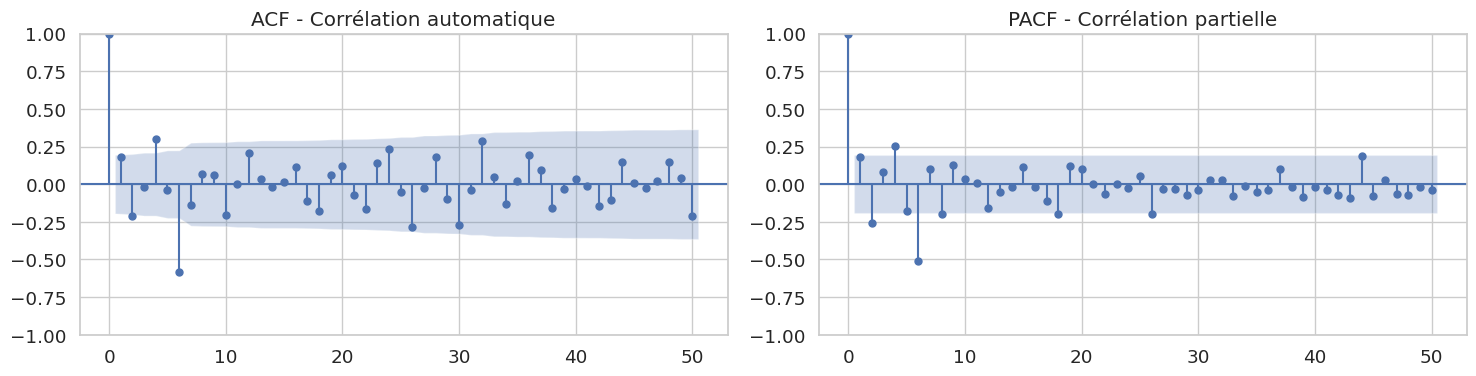

In [45]:
test_stationarity_with_adf(sarimaLessSixMonth['consommation_corrigees'], lags=60, title="Analyse de la série 'valeurs'")

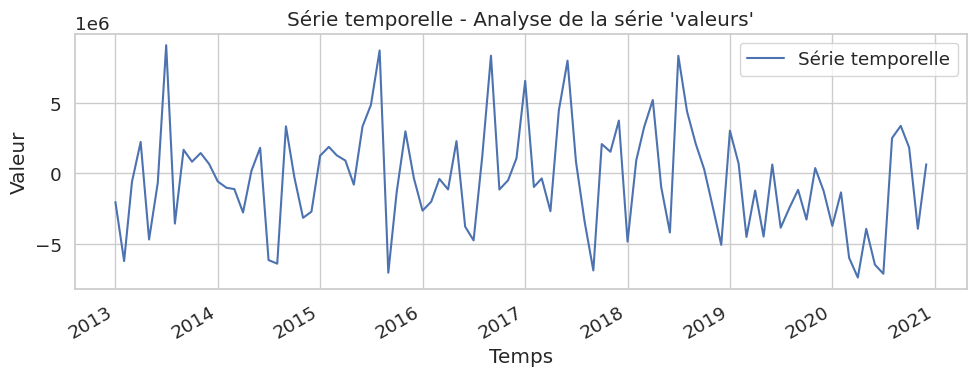

=== Test de Dickey-Fuller augmenté ===
ADF Statistic : -2.480574576523998
p-value : 0.1202725620642715
# lags used : 12
# observations : 83
Valeurs critiques :
   1% : -3.5117123057187376
   5% : -2.8970475206326833
   10% : -2.5857126912469153

❌ La série n'est PAS stationnaire (on ne rejette pas H0)


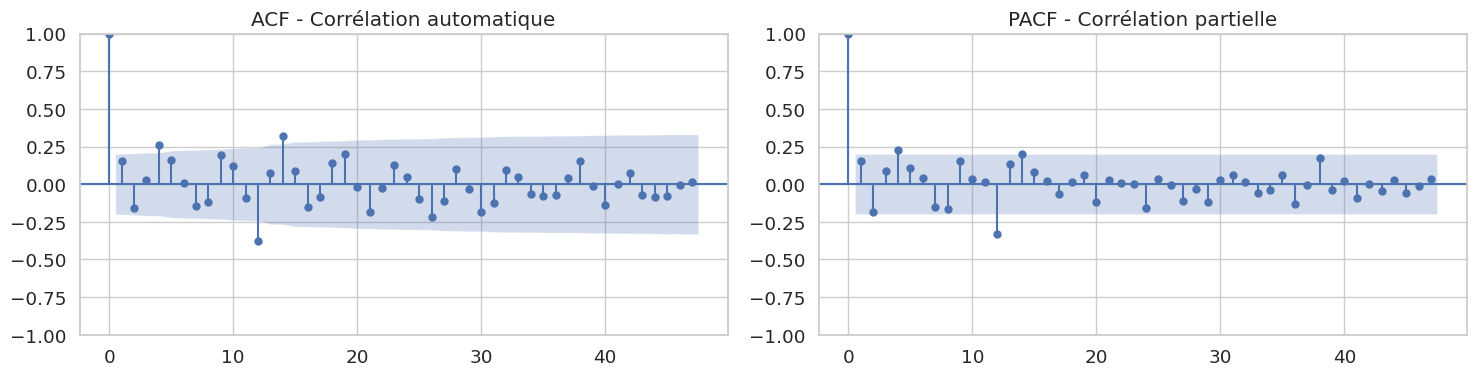

In [46]:
sarimaLessTwelveMonth = cpDfSarima[numerical_cols] - cpDfSarima[numerical_cols].shift(12)
test_stationarity_with_adf(sarimaLessTwelveMonth['consommation_corrigees'], lags=60, title="Analyse de la série 'valeurs'")

In [56]:
def ajusterModeleSarima(serie, previsionsMonths=12):
    """
    Ajuste un modèle SARIMA (avec paramètres fixés) à la série temporelle fournie.
    """
    modele = SARIMAX(
        serie,
        order=(1, 1, 1),               # ARIMA(p,d,q)
        seasonal_order=(1, 1, 1, 12),  # Saisonnière (P,D,Q,s)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultat = modele.fit(disp=False)
    return resultat

In [68]:
def previsionSarima(dataframe, mode="prediction"):
    warnings.filterwarnings("ignore")

    folder = "resources/img"

    if "date" not in dataframe.columns:
        raise KeyError("La colonne 'date' est absente du DataFrame.")

    dataframe["date"] = pd.to_datetime(dataframe["date"])
    dataframe.set_index("date", inplace=True)
    serie = dataframe["consommation_corrigees"]
    dateMax = serie.index.max()

    plt.figure(figsize=(12, 5))

    if mode == "prediction":
        plt.plot(serie, label="Réel", color="blue")
        prochainesDates = pd.date_range(start=dateMax + pd.DateOffset(months=1), periods=12, freq="MS")

        modele = ajusterModeleSarima(serie)
        prevision = pd.Series(modele.forecast(12), index=prochainesDates)

        plt.plot(prevision, "--", label="Prévision SARIMA", color="red")

    elif mode == "checkin_forecast":
        dateDebutVerif = dateMax - pd.DateOffset(months=24)
        serieTrain = serie[serie.index < dateDebutVerif]
        if serieTrain.empty:
            raise ValueError("Série d'entraînement vide.")

        datesPrevision = pd.date_range(start=dateDebutVerif, periods=24, freq="MS")
        modele = ajusterModeleSarima(serieTrain)
        prevision = pd.Series(modele.forecast(24), index=datesPrevision)

        plt.plot(serie, label="Réel", color="blue")
        plt.plot(prevision, "--", label="Prévision SARIMA", color="red")

        indicesCommuns = prevision.index.intersection(serie.index)
        mape = mean_absolute_percentage_error(
            serie.loc[indicesCommuns],
            prevision.loc[indicesCommuns]
        )
        print(f"MAPE : {mape:.2%}")

    else:
        raise ValueError("Mode inconnu. Utilise 'prediction' ou 'checkin_forecast'.")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if mode == "prediction":
        plt.savefig(f"{folder}/sarima_prediction.png")
    elif mode == "checkin_forecast": 
        plt.savefig(f"{folder}/sarima_checkin.png")
    
    plt.show()

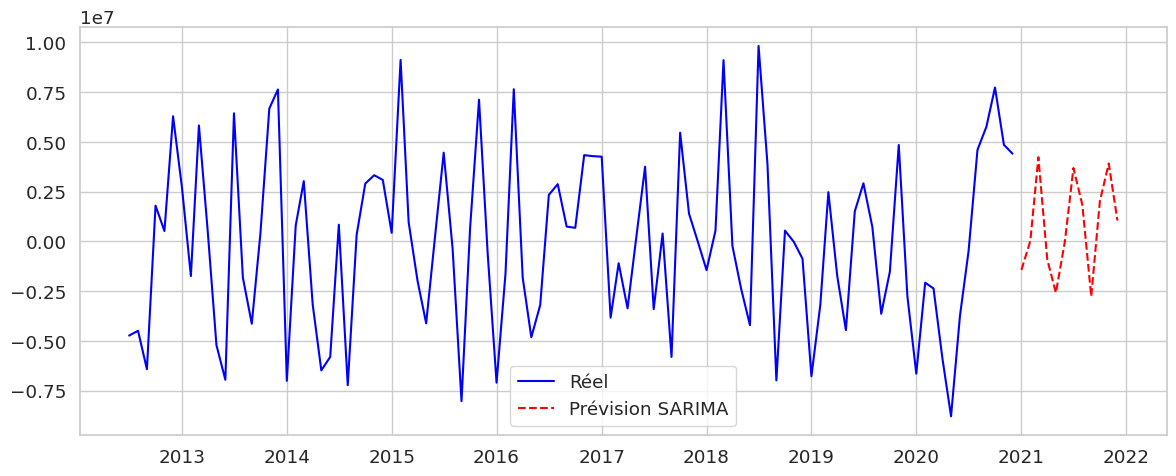

In [69]:
previsionSarima(sarimaLessSixMonth.reset_index())

MAPE : 148.26%


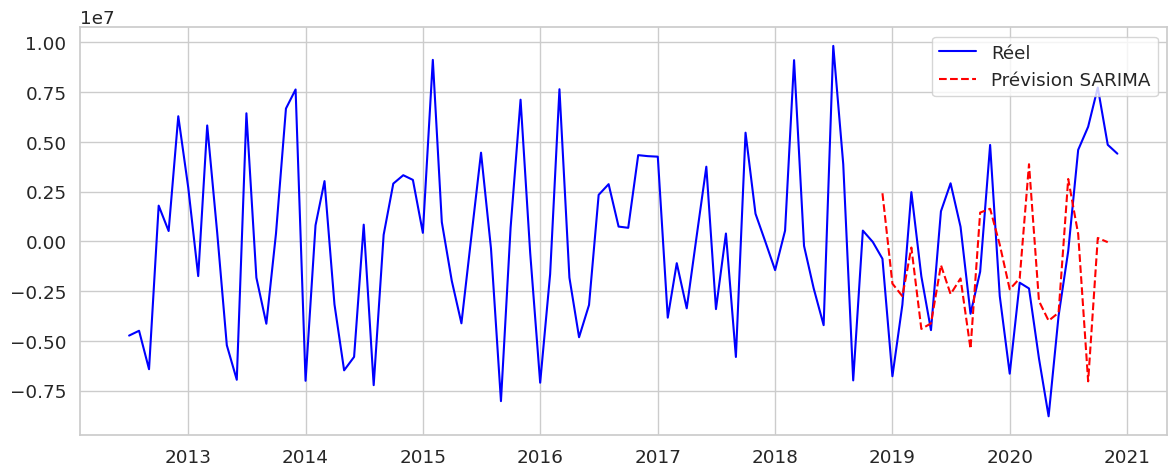

In [70]:
previsionSarima(sarimaLessSixMonth.reset_index(), mode = "checkin_forecast")

In [71]:
def comparerPrevisions(
    dataframe,
    mode="prediction",
    anneeMax=None,
    suffixe="",
    cheminEnregistrement=None
):
    warnings.filterwarnings("ignore")
    folder = "resources/img"

    # Vérifie la colonne 'date'
    if "date" not in dataframe.columns:
        raise KeyError("La colonne 'date' est absente du DataFrame.")

    # Prétraitement
    dataframe["date"] = pd.to_datetime(dataframe["date"])
    dataframe.set_index("date", inplace=True)
    serieConsommationCorrigee = dataframe["consommation_corrigees"]

    # Déterminer date maximale
    if isinstance(anneeMax, (int, str)):
        dateMaximale = pd.to_datetime(f"{int(anneeMax)}-12-31")
    elif isinstance(anneeMax, pd.Timestamp):
        dateMaximale = anneeMax
    else:
        dateMaximale = serieConsommationCorrigee.index.max()

    plt.figure(figsize=(14, 6))

    if mode == "prediction":
        # Tracer série réelle
        plt.plot(
            serieConsommationCorrigee.index,
            serieConsommationCorrigee,
            label="Série réelle",
            color="blue",
            linewidth=2
        )

        previsionsMonths = 12
        prochainesDates = pd.date_range(
            start=dateMaximale + pd.DateOffset(months=1),
            periods=previsionsMonths,
            freq="MS"
        )

        # SARIMA
        modeleSarima = ajusterModeleSarima(serieConsommationCorrigee, previsionsMonths)
        previsionSarima = pd.Series(modeleSarima.forecast(previsionsMonths), index=prochainesDates)
        plt.plot(previsionSarima.index, previsionSarima, linestyle="--", label="SARIMA", color="red", alpha=0.8)

        # Holt-Winters
        modeleHW = ajusterModeleHoltWinters(serieConsommationCorrigee)
        previsionHW = modeleHW.forecast(previsionsMonths)
        seriePrevisionHW = pd.Series(np.asarray(previsionHW), index=prochainesDates[:len(previsionHW)])
        plt.plot(seriePrevisionHW.index, seriePrevisionHW, linestyle=":", label="Holt-Winters", color="green", alpha=0.8)

    elif mode == "checkin_forecast":
        # Tracer toute la série réelle
        plt.plot(
            serieConsommationCorrigee.index,
            serieConsommationCorrigee,
            label="Série réelle",
            color="blue",
            linewidth=2
        )

        # Période de vérification = 24 derniers mois
        dateDebutVerification = dateMaximale - pd.DateOffset(months=24)
        masque = (serieConsommationCorrigee.index >= dateDebutVerification) & (
            serieConsommationCorrigee.index <= dateMaximale
        )

        # Tracer la période de vérification
        plt.plot(
            serieConsommationCorrigee.loc[masque].index,
            serieConsommationCorrigee.loc[masque],
            label="Vérification (2 ans)",
            color="black",
            linewidth=2
        )

        # Série d'entraînement
        serieEntrainement = serieConsommationCorrigee[serieConsommationCorrigee.index < dateDebutVerification]
        if serieEntrainement.empty:
            raise ValueError("La série d'entraînement est vide. Vérifie la date de début de vérification.")

        previsionsMonths = 24
        datesPrevision = pd.date_range(start=dateDebutVerification, periods=previsionsMonths, freq="MS")

        # SARIMA
        modeleSarima = ajusterModeleSarima(serieEntrainement, previsionsMonths)
        previsionSarima = pd.Series(modeleSarima.forecast(previsionsMonths), index=datesPrevision)
        plt.plot(previsionSarima.index, previsionSarima, linestyle="--", label="SARIMA", color="red")

        indicesCommunsSarima = previsionSarima.index.intersection(serieConsommationCorrigee.index)
        mapeSarima = mean_absolute_percentage_error(
            serieConsommationCorrigee.loc[indicesCommunsSarima],
            previsionSarima.loc[indicesCommunsSarima]
        )
        print(f"MAPE SARIMA : {mapeSarima:.2%}")

        # Holt-Winters
        modeleHW = ajusterModeleHoltWinters(serieEntrainement)
        previsionHW = modeleHW.forecast(previsionsMonths)
        seriePrevisionHW = pd.Series(np.asarray(previsionHW), index=datesPrevision[:len(previsionHW)])
        plt.plot(seriePrevisionHW.index, seriePrevisionHW, linestyle=":", label="Holt-Winters", color="green")

        indicesCommunsHW = seriePrevisionHW.index.intersection(serieConsommationCorrigee.index)
        mapeHW = mean_absolute_percentage_error(
            serieConsommationCorrigee.loc[indicesCommunsHW],
            seriePrevisionHW.loc[indicesCommunsHW]
        )
        print(f"MAPE Holt-Winters : {mapeHW:.2%}")

    else:
        raise ValueError(f"Mode inconnu : {mode}. Utilise 'prediction' ou 'checkin_forecast'.")

    # Finalisation du graphique
    plt.title(f"Comparaison des prévisions – Mode: {mode} {suffixe}")
    plt.xlabel("Date")
    plt.ylabel("Consommation corrigée")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if mode == "prediction":
        plt.savefig(f"{folder}/compare_previsions_prediction.png")
    elif mode == "checkin_forecast": 
        plt.savefig(f"{folder}/compare_previsions_checkin.png")
        
    plt.show()

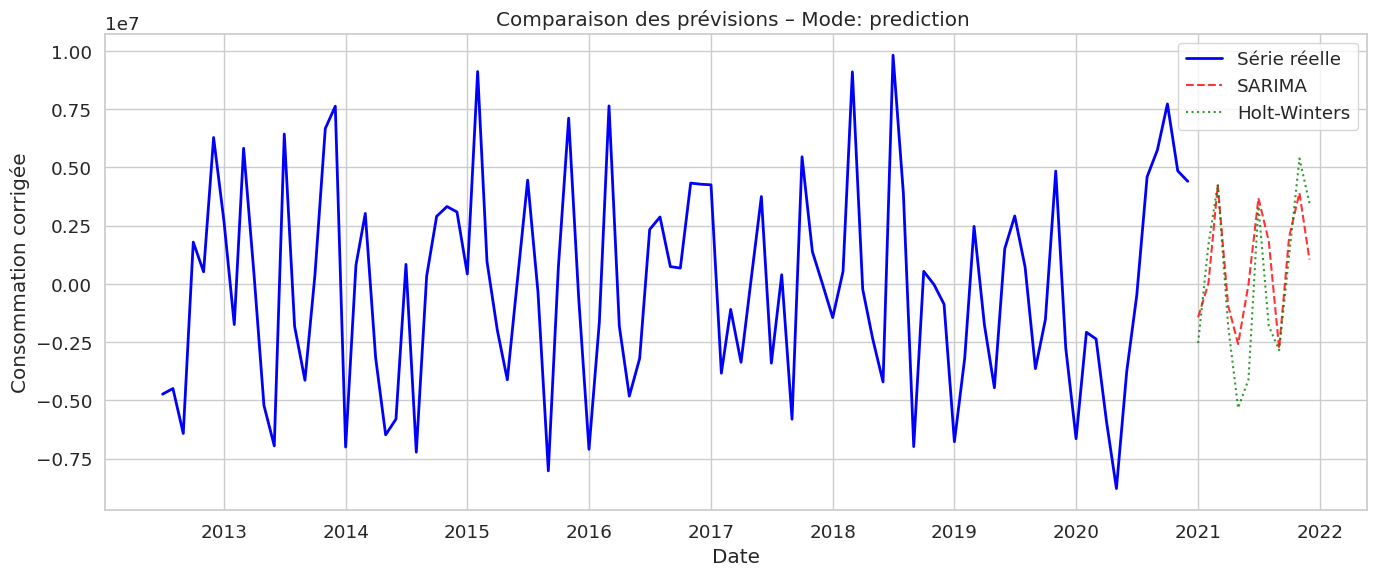

In [74]:
stationary = pd.read_csv("resources/data/valid/stationary.csv", parse_dates=True)
comparerPrevisions(stationary)

MAPE SARIMA : 148.26%
MAPE Holt-Winters : 175.94%


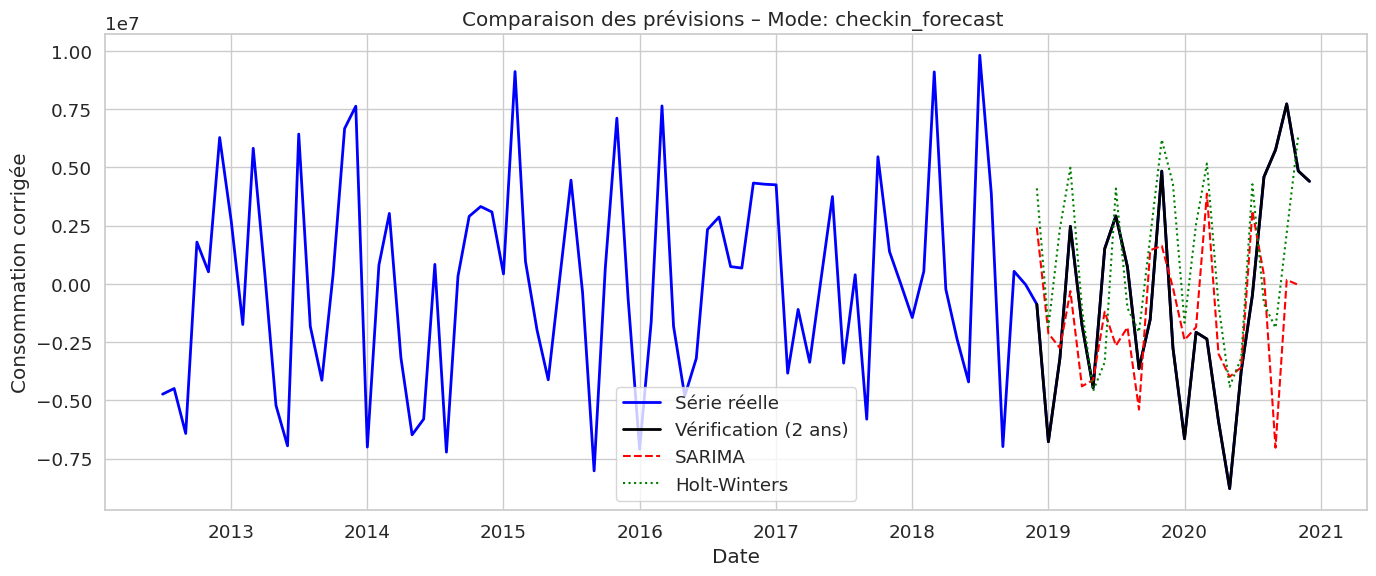

In [73]:
comparerPrevisions(stationary.reset_index(), mode = "checkin_forecast")

## 📈 Analyse des Prévisions - Mode `prediction` (2021–2022)

En analysant le graphique de prédiction, voici les conclusions :

- **SARIMA** fournit une courbe prévisionnelle avec des fluctuations plus réalistes, cohérentes avec les tendances passées de la série (forte variabilité et saisonnalité).
- **Holt-Winters** tend à lisser excessivement les données, ce qui donne une prédiction trop "plate" ou atténuée, moins représentative de la dynamique réelle de la consommation.

🔎 **Visuellement, SARIMA** :
- Anticipe mieux les hausses et baisses attendues.
- Reste plus crédible pour un usage opérationnel (ex. planification, gestion de capacité).

---

## ✅ Vérification des Modèles - Mode `checkin_forecast` (2019–2020)

Sur la période de vérification (les deux dernières années), les erreurs mesurées (MAPE) sont :
- **SARIMA : 148.26 %**
- **Holt-Winters : 175.94 %**

🔎 Cela confirme que **SARIMA** est également **meilleur en performance chiffrée**, malgré une erreur encore importante à cause de la forte volatilité des données.

---

## 🧠 Conclusion Finale

> **Le modèle SARIMA est globalement le plus adapté pour prédire la consommation corrigée dans ce cas**, aussi bien d’un point de vue visuel que statistique. Il gère mieux la saisonnalité complexe et les variations brusques observées dans la série.
